<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/lesson6_pets_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: pets revisited

In [0]:
#!curl https://course-v3.fast.ai/setup/colab | bash
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install fastai
!pip3 install Pillow==4.1.1

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
bs = 64 

In [0]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

上で読み込んだペットの画像に対して，データ増大を適用する．

* max_rorate: 最大回転
* max_zoom: 最大拡大
* max_lighting: 最大輝度


* do_flip: if True, a random flip is applied with probability 0.5
* flip_vert: requires do_flip=True. If True, the image can be flipped vertically or rotated of 90 degrees, otherwise only an horizontal flip is applied
* max_rotate: if not None, a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
* max_zoom: if not 1. or less, a random zoom betweem 1. and max_zoom is applied with probability p_affine
* max_lighting: if not None, a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
* max_warp: if not None, a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
* p_affine: the probability that each affine transform and symmetric warp is applied
* p_lighting: the probability that each lighting transform is applied
* xtra_tfms: a list of additional transforms you would like to be applied

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
doc(get_transforms)

In [0]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

上で作成したデータ読み込み＋ラベル付け＋変形（データ増大）＋正規化を適用し，データ束インスタンスを得る．

In [0]:
data = get_data(224, bs, 'zeros')

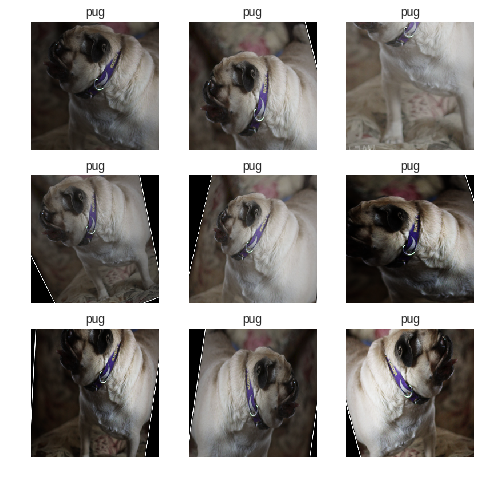

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data = get_data(224,bs)

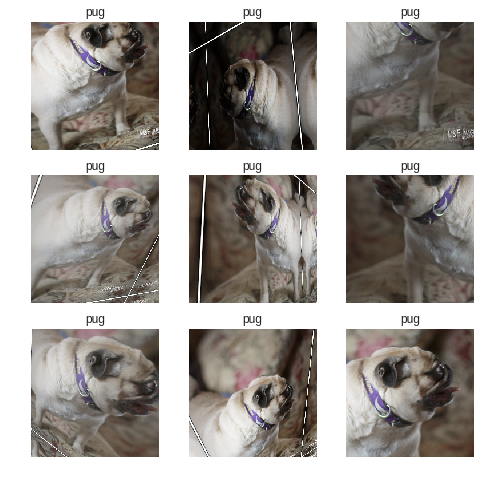

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

残差ネットワークresnet34を最終層のバッチ正規化を行うように設定して，学習器learnを生成する．


In [12]:
gc.collect() #ガーベッジコレクター
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 21280168.86it/s]


In [21]:
learn.fit_one_cycle(1, slice(1e-2), pct_start=0.8) #pct_startはアニーリングのcosをなにやら決めるパラメータ

epoch,train_loss,valid_loss,error_rate


Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken p

KeyboardInterrupt: ignored

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

Total time: 00:44
epoch  train_loss  valid_loss  error_rate
1      0.695697    0.286645    0.064276    (00:22)
2      0.636241    0.295290    0.066982    (00:21)



In [0]:
data = get_data(352,bs)
learn.data = data

In [24]:
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,1.312450,0.743944,0.092016


In [0]:
learn.save('352')

## Convolution kernel

In [0]:
data = get_data(352,16) #大きいサイズ352で読み込み（バッチサイズは１６と小さくする）

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category wheaten_terrier

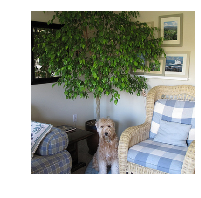

In [28]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [0]:
from fastai.callbacks.hooks import *

In [31]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [32]:
k.shape

torch.Size([1, 3, 3, 3])

In [33]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [34]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

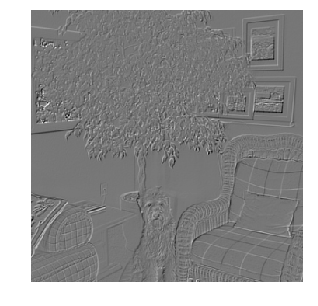

In [36]:
show_image(edge[0], figsize=(5,5));

In [37]:
data.c

37

In [38]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [39]:
learn.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [16, 64, 176, 176]   9408       False     \n______________________________________________________________________\nBatchNorm2d          [16, 64, 176, 176]   128        True      \n______________________________________________________________________\nReLU                 [16, 64, 176, 176]   0          False     \n______________________________________________________________________\nMaxPool2d            [16, 64, 88, 88]     0          False     \n______________________________________________________________________\nConv2d               [16, 64, 88, 88]     36864      False     \n______________________________________________________________________\nBatchNorm2d          [16, 64, 88, 88]     128        True      \n________________________________________

## Heatmap

どの部分が分類に役に立ったのかをヒートマップで表す．

畳み込みの最終層 acts をもってくる．これは512チャネル（特徴を表す）の11*11のテンソルである．

512の特徴の平均をとると，11*11のどの部分を利用して分類したかが分かる．

これをmatplotlibで元の画像の大きさ352に引き延ばして表示すると，ヒートマップになる．


In [0]:
m = learn.model.eval();

In [0]:
xb,_ = data.one_item(x)　#画像データから1バッチ分のデータxbを作る．
xb_im = Image(data.denorm(xb)[0])
#xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: #m[0]は畳み込み層であり，そこに1バッチ分の猫の画像データを入れる．
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [45]:
acts  = hook_a.stored[0].cpu() 
acts.shape

torch.Size([512, 11, 11])

In [46]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

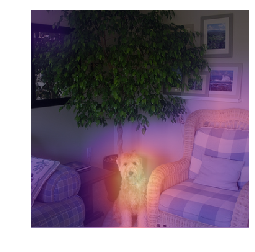

In [48]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [49]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

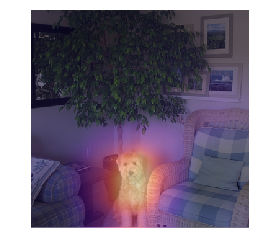

In [51]:
show_heatmap(mult)

In [0]:
fn = path/'../other/bulldog_maine.jpg'

In [53]:
x = open_image(fn); x

FileNotFoundError: ignored

In [54]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

RuntimeError: ignored

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

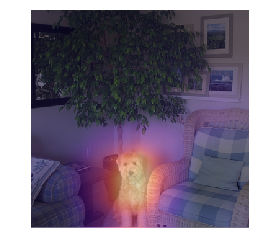

In [57]:
show_heatmap(mult)

In [58]:
data.classes[0]

'Abyssinian'

In [0]:
hook_a,hook_g = hooked_backward(0)

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

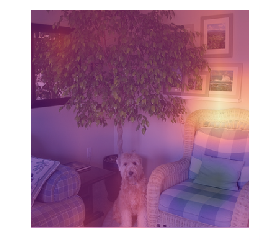

In [61]:
show_heatmap(mult)

## fin